# 03 - Análise Exploratória

## 3.1-Hipótese
##3.2-TESTE DE HIPÓTESE
##3.2.1-Clusterização
##3.2.1.1-Tratamento dos dados para clusterização
##3.2.1.2- Método Elbow para seleção de número de clusters
##3.2.1.3 - Aplicação do algoritmo KMeans e análise dos clusters gerados
##3.2.1.3.1 - Distribuição percentual das fases da operação por cluster
#3.2.3-Cluster 0
#3.2.2-Cluster 1
#3.2.3-Cluster 2
###3.3-Gráfico PCA
###3.4- Análise estatística
###3.5- Conclusão e recomendações


# 03 - Análise Exploratória

- Este notebook tem como objetivo realizar uma análise exploratória das ocorrências aeronáuticas, com foco em entender padrões temporais, fatores contribuintes e aspectos críticos dos acidentes e incidentes registrados.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA


In [2]:
df_ocorrencias = pd.read_csv('/content/drive/MyDrive/DESAFIOA3DATA/base_tratada/df_ocorrencias_finalizadas.csv')
df_ocorrencias.head()

,codigo_ocorrencia,classificacao,tipo,localidade,uf,pais,aerodromo,dia_ocorrencia,horario,sera_investigada,...,fator_area_FATOR HUMANO,fator_area_FATOR MATERIAL,fator_area_FATOR OPERACIONAL,fator_area_OUTRO,ano,mes,dia,ano_de_fabricacao,grupo_ano_fab,nivel_dano_num
0,50313,INCIDENTE GRAVE,POUSO SEM TREM,CACOAL,RO,BRASIL,SSKW,2013-11-25,12:32:00,SIM,...,0.0,0.0,1.0,0.0,2013,11,25,1980.0,1980–2000,2.0
1,34078,ACIDENTE,PERDA DE CONTROLE NO SOLO,CEREJEIRAS,RO,BRASIL,NaN,2008-08-07,15:10:00,SIM,...,0.0,0.0,1.0,0.0,2008,8,7,1981.0,1980–2000,2.0
2,44988,ACIDENTE,POUSO LONGO,AMAJARI,RR,BRASIL,NaN,2011-08-11,17:00:00,SIM,...,0.0,0.0,1.0,1.0,2011,8,11,1981.0,1980–2000,2.0
3,43063,ACIDENTE,PERDA DE CONTROLE EM VOO,ALTO ALEGRE,RR,BRASIL,NaN,2010-09-21,17:10:00,SIM,...,1.0,0.0,1.0,1.0,2010,9,21,1980.0,1980–2000,2.0
4,45280,ACIDENTE,FALHA DO MOTOR EM VOO,ALTO ALEGRE,RR,BRASIL,NaN,2011-11-22,16:40:00,SIM,...,0.0,0.0,1.0,0.0,2011,11,22,1973.0,Antes de 1980,3.0


## 3.1-Hipótese:
#** Existem perfis distintos de ocorrências aeronáuticas que se agrupam segundo características da aeronave (como número de motores, peso e assentos),  fatores contribuintes (humano, material, operacional, etc.) e fases de operação (pouso, decolagem, cruzeiro, manobra, etc).**

##3.2-TESTE DE HIPÓTESE

##3.2.1-Clusterização

In [3]:
#Seleção de variáveis pertinentes para a clusterização por coluna em df_ocorrencias.columns:
for col in df_ocorrencias.columns:
    print(f"Coluna: {col}")
    print(f"Tipo: {df_ocorrencias[col].dtype}")
    print(f"Quantidade de valores únicos: {df_ocorrencias[col].nunique()}")
    print(f"Amostra de dados: {df_ocorrencias[col].sample(min(5, len(df_ocorrencias[col]))).tolist()}")
    print("-" * 30)

Coluna: codigo_ocorrencia
Tipo: int64
Quantidade de valores únicos: 1059
Amostra de dados: [49619, 38425, 27809, 28377, 49617]
------------------------------
Coluna: classificacao
Tipo: object
Quantidade de valores únicos: 2
Amostra de dados: ['ACIDENTE', 'INCIDENTE GRAVE', 'ACIDENTE', 'ACIDENTE', 'INCIDENTE GRAVE']
------------------------------
Coluna: tipo
Tipo: object
Quantidade de valores únicos: 43
Amostra de dados: ['FALHA DE SISTEMA / COMPONENTE', 'COM TREM DE POUSO', 'COM COMANDOS DE VOO', 'COLISÃO COM OBSTÁCULO NO SOLO', 'POUSO SEM TREM']
------------------------------
Coluna: localidade
Tipo: object
Quantidade de valores únicos: 513
Amostra de dados: ['BALSAS', 'PONTA GROSSA', 'SANTA RITA DE CÁSSIA', 'BOA ESPERANÇA DO SUL', 'JUIZ DE FORA']
------------------------------
Coluna: uf
Tipo: object
Quantidade de valores únicos: 27
Amostra de dados: ['SP', 'MT', 'SP', 'BA', 'MS']
------------------------------
Coluna: pais
Tipo: object
Quantidade de valores únicos: 1
Amostra de da

- A Clusterização é um método de aprendizado não supervisionado que busca agrupar os dados de acordo com similaridades intrínsecas, sem precisar de rótulos prévios.

- O objetivo é descobrir se os dados naturalmente formam grupos com características semelhantes. Por exemplo, se existem clusters que representam aeronaves pequenas em fase de decolagem com fatores humanos prevalentes, enquanto outros agrupam aeronaves maiores com predominância de fatores materiais.


- A clusterização permite combinar variáveis contínuas (como peso, quantidade de motores), binárias (fatores contribuintes) e categóricas (fase_operacao), essas últimas transformadas por one-hot encoding, para formar um perfil multidimensional dos dados.


- Em resumo, agrupar as ocorrências em clusters ajuda a identificar padrões ou perfis que podem passar despercebidos em análises simples. Isso pode guiar ações específicas para cada perfil, como intervenções focadas em determinados fatores ou fases da operação.

##3.2.1.1-Tratamento dos dados para clusterização

- Para preparar os dados para clusterização, foram selecionadas variáveis relacionadas às características da aeronave (quantidade de motores, peso máximo de decolagem, assentos, nível de dano), fatores contribuintes binários e a fase da operação. As variáveis numéricas foram normalizadas para eliminar diferenças de escala, garantindo peso equivalente no agrupamento. A variável categórica fase_operacao foi convertida em variáveis binárias por one-hot encoding, permitindo sua inclusão no modelo sem hierarquia implícita. Por fim, todas as variáveis foram concatenadas em uma única matriz, que serve como base para aplicar o algoritmo KMeans, garantindo a comparação adequada entre as diferentes características.

In [4]:
# Seleção de colunas para cluster
cols = ['quantidade_motores', 'peso_maximo_decolagem', 'quantidade_assentos',
        'fator_area_FATOR HUMANO', 'fator_area_FATOR MATERIAL',
        'fator_area_FATOR OPERACIONAL', 'fator_area_OUTRO',
        'nivel_dano_num', 'fase_operacao']

df_cluster = df_ocorrencias[cols].dropna()

# Normalização das variáveis numéricas
num_cols = ['quantidade_motores', 'peso_maximo_decolagem', 'quantidade_assentos', 'nivel_dano_num']
scaler = StandardScaler()
num_scaled = scaler.fit_transform(df_cluster[num_cols])
X_num = pd.DataFrame(num_scaled, columns=[c + '_scaled' for c in num_cols])

# Seleção das variáveis binárias dos fatores
X_fatores = df_cluster[['fator_area_FATOR HUMANO', 'fator_area_FATOR MATERIAL',
                        'fator_area_FATOR OPERACIONAL', 'fator_area_OUTRO']].reset_index(drop=True)

# One-hot encoding da variável fase_operacao
X_fase = pd.get_dummies(df_cluster['fase_operacao'], prefix='fase').reset_index(drop=True)

# Concatenação
X = pd.concat([X_num, X_fatores, X_fase], axis=1)




##3.2.1.2- Método Elbow para seleção de número de clusters

- O Método Elbow ajuda a decidir quantos clusters usar na análise. Ele roda o KMeans com diferentes números de clusters e calcula a inércia, que mostra o quão compactos os grupos são. No gráfico da inércia versus número de clusters, buscamos o “cotovelo” do gráfico, que é o ponto onde a melhora na compactação começa a diminuir. Esse ponto indica o número ideal de clusters para equilibrar simplicidade e qualidade do agrupamento.

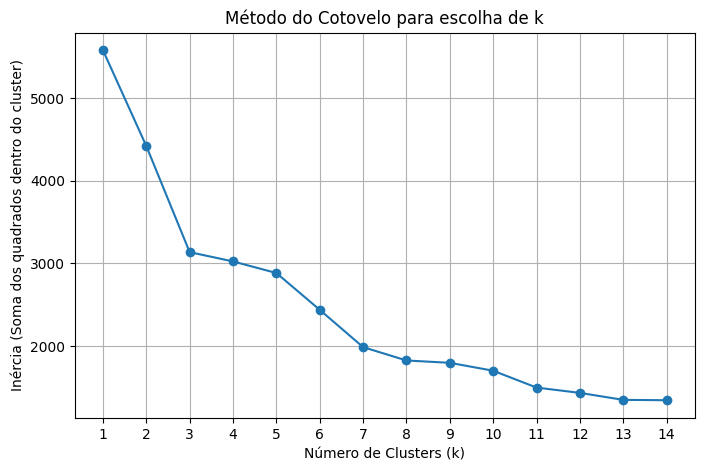

In [5]:
k_range = range(1, 15)
inertia_values = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_range, inertia_values, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia (Soma dos quadrados dentro do cluster)')
plt.title('Método do Cotovelo para escolha de k')
plt.xticks(k_range)
plt.grid(True)
plt.show()

- É observado o "cotovelo" indicando 3 como o número ideal de Clusters (K)

##3.2.1.3 - Aplicação do algoritmo KMeans e análise dos clusters gerados

- O código executa o algoritmo KMeans com 3 clusters e adiciona os grupos identificados ao dataframe. Depois, calcula a média das variáveis numéricas e a prevalência dos fatores contribuintes para cada cluster, além de mostrar a distribuição das fases de operação. Isso permite entender as características e diferenças entre os perfis formados.

In [6]:
# Seleção de Kmeans (Quantidade de clusters)
kmeans = KMeans(n_clusters=3, random_state=42) #clusters igual a 3
clusters = kmeans.fit_predict(X)

# Adicição do cluster ao dataset original
df_cluster = df_cluster.reset_index(drop=True)
df_cluster['cluster'] = clusters

# Análise resumo por cluster
print(df_cluster.groupby('cluster').mean(numeric_only=True))

# Prevalência média dos fatores por cluster
print(df_cluster.groupby('cluster')[['fator_area_FATOR HUMANO', 'fator_area_FATOR MATERIAL',
                                     'fator_area_FATOR OPERACIONAL', 'fator_area_OUTRO']].mean())

# Distribuição de fase_operacao por cluster
tabela_fase = df_cluster.pivot_table(index='cluster',
                                    columns='fase_operacao',
                                    aggfunc='size',
                                    fill_value=0)

# Normalização para percentuais por cluster
tabela_fase_percent = tabela_fase.div(tabela_fase.sum(axis=1), axis=0) * 100

# Mostrar a tabela arredondada para 2 casas decimais
print(tabela_fase_percent.round(2))


         quantidade_motores  peso_maximo_decolagem  quantidade_assentos  \
cluster                                                                   
0                  2.000000            3676.466667             8.779167   
1                  0.992386            1393.916244             3.319797   
2                  2.187500          110263.187500           134.812500   

         fator_area_FATOR HUMANO  fator_area_FATOR MATERIAL  \
cluster                                                       
0                       0.275000                   0.033333   
1                       0.167513                   0.021574   
2                       0.500000                   0.062500   

         fator_area_FATOR OPERACIONAL  fator_area_OUTRO  nivel_dano_num  
cluster                                                                  
0                            0.783333          0.125000        1.900000  
1                            0.720812          0.086294        1.979695  
2           

##3.2.1.3.1 - Distribuição percentual das fases da operação por cluster

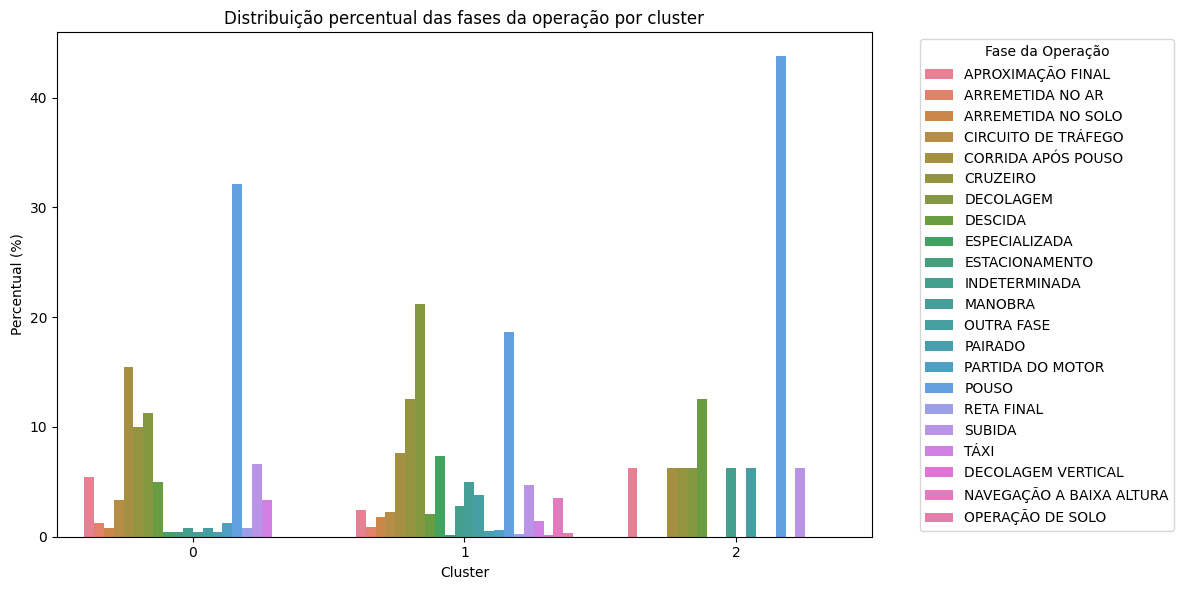

In [7]:
fase_dist = df_cluster.groupby(['cluster', 'fase_operacao']).size().reset_index(name='count')
fase_dist['percent'] = fase_dist.groupby('cluster')['count'].transform(lambda x: 100 * x / x.sum())

plt.figure(figsize=(12, 6))
sns.barplot(data=fase_dist, x='cluster', y='percent', hue='fase_operacao')
plt.title('Distribuição percentual das fases da operação por cluster')
plt.ylabel('Percentual (%)')
plt.xlabel('Cluster')
plt.legend(title='Fase da Operação', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#3.2.3-Cluster 0 - aeronaves de pequeno porte
- Peso médio: ~3.676 kg
- Assentos: ~9
- Dano médio: ~1.9 (substancial)

###Fatores mais comuns:

- Operacional: 78%
- Humano: 27%

###Fases mais frequentes:

- Pouso (32%)
- Corrida após pouso (15%)
- Decolagem e cruzeiro

- Esse cluster representa aeronaves de pequeno porte usadas em voos regionais ou privados, com acidentes ocorrendo principalmente durante o pouso ou manobras finais. Fatores operacionais e humanos são altamente prevalentes.



#3.2.2-Cluster 1 - Aeronaves muito leves

- Peso: ~1.393 kg
- Assentos: ~3,3
- Dano médio: ~2.0 (substancial)

###Fatores mais comuns:

- Operacional: 72%
- Humano: 17% (mais baixo entre os clusters)

###Fases mais frequentes:

- Muito variadas: decolagem, pouso, cruzeiro, manobra, subida, etc.

- Aeronaves muito leves, usadas para instrução, agrícola, ou voos particulares diversos. A presença do fator operacional é alta, mas há menor associação com erro humano. Maior variabilidade nas fases sugere comportamento mais disperso e complexo.



#3.2.3-Cluster 2 - aviões comerciais de grande porte

- Motores: ~2.19
- Peso: ~110.263 kg (!!)
- Assentos: ~135
- Dano: mais leve (~0.94)

###Fatores mais frequentes:

- Operacional: 87%
- Humano: 50%

###Fases mais frequentes:

- Principalmente pouso (44%)
- Outras fases (descida, aproximação) também relevantes

-Esse grupo representa aviões comerciais de grande porte. É o único cluster com grande associação a acidentes menos graves, o que condiz com protocolos de segurança mais rígidos. No entanto, o fator humano se destaca, apontando para desafios operacionais mesmo com boa infraestrutura.




###3.3-Gráfico PCA

- O gráfico apresentado utiliza a técnica de Análise de Componentes Principais (PCA) para reduzir a dimensionalidade dos dados e permitir a visualização dos clusters em duas dimensões (PC1 e PC2).

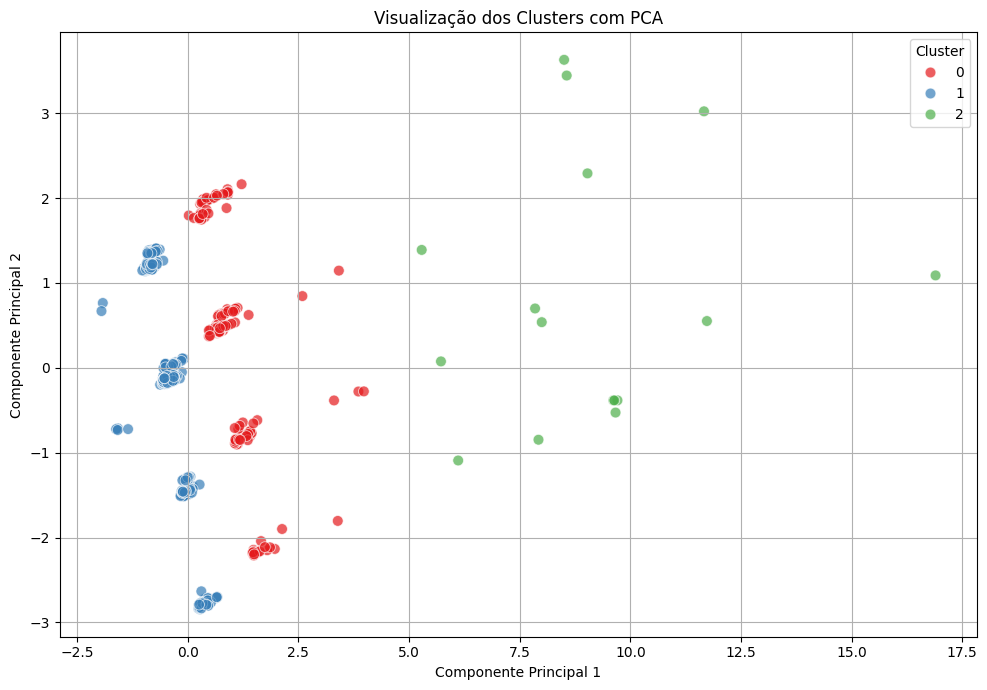

In [8]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# DataFrame com coordenadas PCA e clusters
df_vis = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_vis['cluster'] = df_cluster['cluster'].values

# Scatterplot
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_vis, x='PC1', y='PC2', hue='cluster', palette='Set1', alpha=0.7, s=60)
plt.title('Visualização dos Clusters com PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()


###3.4- Análise estatística

In [9]:
labels = clusters

X_array = X.values

# Calcular métricas
sil_score = silhouette_score(X_array, labels)
ch_score = calinski_harabasz_score(X_array, labels)
db_score = davies_bouldin_score(X_array, labels)

print(f"Silhouette Score: {sil_score:.3f}")
print(f"Calinski-Harabasz Index: {ch_score:.3f}")
print(f"Davies-Bouldin Index: {db_score:.3f}")



Silhouette Score: 0.352
Calinski-Harabasz Index: 405.516
Davies-Bouldin Index: 1.131


##Silhouette Score = 0.352
- Indica uma separação razoável entre os clusters, mas não muito forte. Geralmente valores acima de 0.5 são considerados bons; valores entre 0.25 e 0.5 indicam clusters moderadamente separados, o que é comum em dados reais com variabilidade alta.

##Calinski-Harabasz Index = 405.516
-Esse valor por si só não tem um limite fixo, mas quanto maior, melhor. Comparado a outras tentativas de clusterização (ex: diferentes k), um valor alto indica boa separação relativa entre os clusters.

##Davies-Bouldin Index = 1.131
- Valores abaixo de 1 indicam clusters bem separados; 1.131 é próximo disso, mostrando sobreposição.


- A clusterização gerou grupos com certa coesão e separação, mas ainda tem espaço para melhoria.

## Ideias para tentar melhorar a clusterização:

- Testar diferentes números de clusters (k);
- Avaliar se outras features podem melhorar a segmentação.


- Para muitos problemas reais, esses resultados já são úteis e podem ser interpretados para insights.



###3.5- Conclusão e recomendações


- Com base na clusterização realizada sobre as ocorrências aeronáuticas, foi possível identificar três perfis bem distintos de acidentes, fortemente associados a características técnicas das aeronaves (peso, número de assentos e motores) fatores contribuintes e fases do voo.

- A análise revelou que diferentes perfis de aeronaves enfrentam riscos distintos ao longo do ciclo de voo. Estratégias genéricas de mitigação podem falhar se não forem adaptadas à realidade de cada grupo. As evidências obtidas por meio da clusterização podem servir como base para políticas de segurança mais inteligentes e personalizadas.